In [2]:
# # Import necessary libraries

# Standard Python library
import gzip
import os
import random
import shutil
import time
import urllib.request
from collections import Counter

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from dotenv import load_dotenv
from intervaltree import IntervalTree

# Scikit-Learn - Core ML Functionality 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, multilabel_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# Transformers - Pretained BERT models and retraining functions
from transformers import BertModel, BertTokenizer, AutoConfig, Trainer, TrainingArguments, BertForTokenClassification
# from accelerate import Accelerator

# BioPython - NCBI Data Processing and API
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqFeature import CompoundLocation


c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # Change these settings based on use case:

# Use Entrez API to search NCBI for and downlaod genomes
useEntrez = False
maxResults = 10
# True if files already present, false if using remote access via Entrez
directDownload = True
# Directory to store downloaded GBFF files
outDirectory = "../data/downloads"
# True if testing basic DNABERT on data (it sucks)
testbasic = True


In [4]:
# # Create a query and download maxResults GBFF files from NCBI's Assembly database using Entrez API

def searchNcbiAssembly(searchTerm, max):
    """Search NCBI for all bacterial genomes matching the criteria."""
    handle = Entrez.esearch(db="assembly", term=searchTerm, retmax=max)
    record = Entrez.read(handle)
    handle.close()
    
    if record["IdList"]:
        return record["IdList"]  # List of Assembly IDs
    else:
        print("No bacterial genomes found.")
        return []

if useEntrez:
    # Load variables from .env file
    load_dotenv()

    # # Verify they are loaded
    # print("NCBI Email:", Entrez.email)
    # print("NCBI API Key:", Entrez.api_key)

    # Set Entrez API credentials
    Entrez.email = os.getenv("NCBI_EMAIL", None)
    Entrez.api_key = os.getenv("NCBI_API_KEY", None)

    os.makedirs(outDirectory, exist_ok=True)

    # Search term to retrieve annotated bacterial genomes
    searchTerm = '"Bacteria"[Organism] AND "Complete Genome"[AssemblyStatus] AND "latest_refseq"[PropertyList] AND "refseq_has_annotation"[PropertyList] AND "reference genome"[RefSeqCategory]'

    # Get list of bacterial genome assembly IDs
    assemblyIDs = searchNcbiAssembly(searchTerm, maxResults)
    print(assemblyIDs)
else:
    print("Project set to skip use of Entrez API; check that files are already in /data/downloads folder")


Project set to skip use of Entrez API; check that files are already in /data/downloads folder


In [5]:
# # Download each bacterial genome from list of assembly IDs

def getGbffUrl(id):
    """Retrieve the FTP URL for downloading the GBFF file."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
        ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_RefSeq"]
        if not ftpPath:  # If RefSeq is not available, get GenBank version
            # print(f"Skipping {id} (No RefSeq available, only GenBank).")
            # return None
            ftpPath = record["DocumentSummarySet"]["DocumentSummary"][0]["FtpPath_GenBank"]
            if not ftpPath:
                print(f"No FTP path found for assembly {id}")
                return None

        # Construct GBFF file URL
        filename = ftpPath.split("/")[-1] + "_genomic.gbff.gz"
        url = f"{ftpPath}/{filename}"
        return url

    except Exception as e:
        print(f"Error retrieving FTP URL: {e}")
        return None
    
    
def downloadGbffFile(url, outFile):
    """Download the GBFF file from the provided FTP URL."""
    try:
        urllib.request.urlretrieve(url, outFile)
        print(f"Downloaded: {outFile}")
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        
if useEntrez:
    for ID in assemblyIDs:
        URL = getGbffUrl(ID)
        if URL:
            outFile = os.path.join(outDirectory, f"{ID}.gbff.gz")
            downloadGbffFile(URL, outFile)
        
        # Avoid exceeding NCBI rate limits
        time.sleep(1)
else:
    print("Project set to skip use of Entrez API; check that files are already in /data/downloads folder")


Project set to skip use of Entrez API; check that files are already in /data/downloads folder


In [6]:
# # Extract GBFF contents from downloaded .gbff.gz files

def extractFiles(directory):
    """Extract all .gbff.gz files in the directory."""
    for filename in os.listdir(directory):
        if filename.endswith(".gbff.gz"):
            gzPath = os.path.join(directory, filename)
            gbffPath = os.path.join(directory, filename.replace(".gz", ""))

            try:
                # Extract .gbff.gz to .gbff
                with gzip.open(gzPath, "rb") as f_in:
                    with open(gbffPath, "wb") as f_out:
                        shutil.copyfileobj(f_in, f_out)

                print(f"Extracted: {gbffPath}")

                # Delete the .gz file after extraction
                os.remove(gzPath)

            except Exception as e:
                print(f"Failed to extract {gzPath}: {e}")

# Run extraction
extractFiles(outDirectory)


In [7]:
def getTaxonomyRanks(taxonID):
    '''
        Uses taxonID (int) as a query id for NCBI's Entrez API to query the Taxonomy database.
        Processes the returned lineage structure into a dictionary containing the full taxonomy
        of that organism's ID
        Returns a dictionary containing each taxonomic level, or an empty dictionary if ID doesn't
        match any organism
    '''
    handle = Entrez.efetch(db="taxonomy", id=taxonID, retmode="xml")
    records = Entrez.read(handle)
    if records:
        lineage = records[0]["LineageEx"]
        ranks = {entry["Rank"]: entry["ScientificName"] for entry in lineage}
        ranks["species"] = records[0]["ScientificName"]
        return {
            "Domain": ranks.get("domain", None),
            "Kingdom": ranks.get("kingdom", None),
            "Phylum": ranks.get("phylum", None),
            "Class": ranks.get("class", None),
            "Order": ranks.get("order", None),
            "Family": ranks.get("family", None),
            "Genus": ranks.get("genus", None),
            "Species": ranks.get("species", None)
        }
    return {}


In [ ]:
# # Process downloaded GBFF files for model input and/or fine-tuning
# # Most of the captured info is setup for downstream tasks, not necessarily within
# # project's scope

dataDirectory = "../data/downloads"

validGeneTypes = ["CDS", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]

# Optional for downstream tasks:
essentialGenomeElements = [
    "Sequence", "GenomeType", "Genes",
]
essentialGeneElements = [
    "GeneType", "LocusTag", "Start", "End", "GeneLength", "Strand", 
    "IntergenicDistance", "GCContent", "Organism", "RegulatoryClass", 
    "BoundMoiety", "Serovar", "Strain", "Subspecies"
]
OptionalGeneElements = ["GeneName"]

# Examples:
# Gene types:
# ['source', 'gene', 'CDS', 'regulatory', 'protein_bind', 'rRNA', 'tRNA', 'ncRNA', 'mobile_element', 'tmRNA', 'misc_RNA']

# Qualifiers:
# {
#     'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 
#     'mol_type': ['genomic DNA'], 
#     'strain': ['LT2'], 
#     'serovar': ['Typhimurium'], 
#     'sub_species': ['enterica'], 
#     'culture_collection': ['ATCC:700720', 'SGSC:1412'], 
#     'type_material': ['type strain of Salmonella enterica'], 
#     'db_xref': ['taxon:99287'], 
#     'focus': [''],
#     'plasmid': ['pSLT']
# }
if directDownload:
    if not useEntrez: # We will still use Entrez for the taxonomy, so this runs only if it wasn't set in previous cells
        Entrez.email = os.getenv("NCBI_EMAIL", None)
        Entrez.api_key = os.getenv("NCBI_API_KEY", None)

    data = []
    for i, filename in enumerate(os.listdir(dataDirectory)):
        if filename.endswith(".gbff"):
            fullPath = os.path.join(dataDirectory, filename)
            print(f"processing File {i}: {fullPath}")
            # Read the file and parse it as a GenBank record
            with open(fullPath, "r") as input:
                for record in SeqIO.parse(input, "genbank"):
                    accessionNum = record.id
                    genome = record.seq
                    genomeLength = len(genome)
                    description = record.description
                    genomeType = "plasmid" if "plasmid" in description.lower() else "chromo"
                    organism = None
                    subspecies = None
                    moleculeType = None
                    strain = None
                    serovar = None
                    taxonID = None
                    host = None

                    # print(f"Accession: {record.id}")
                    # print(f"Genome Length: {genomeLength} bp")
                    # print(f"Type of genome: {genomeType}")
                    # print(f"Description: {description}")
                                            
                    sourceRegions = None
                    genes = []
                    for gene in record.features:
                        geneType = gene.type
                        geneName = None
                        locusTag = None
                        geneStart = gene.location.start
                        geneEnd = gene.location.end
                        strand = "+" if gene.location.strand == 1 else "-"
                        geneSequence = genome[geneStart:geneEnd]
                        GCContent = (geneSequence.count("G") + geneSequence.count("C")) / len(geneSequence) if len(geneSequence) > 0 else 0

                        proteinProduct = None
                        aminoAcidSeq = None
                        regClass = None
                        boundMoiety = None
                        RNAProduct = None
                        ncRNAClass = None
                        elementType = None

                        # Store all `source` regions
                        if geneType == "source":
                            organism = gene.qualifiers.get("organism", [None])[0]
                            subspecies = gene.qualifiers.get("sub_species", [None])[0]
                            moleculeType = gene.qualifiers.get("mol_type", [None])[0]
                            strain = gene.qualifiers.get("strain", [None])[0]
                            serovar = gene.qualifiers.get("serovar", [None])[0]
                            host = gene.qualifiers.get("host", [None])[0]
                            taxonID = gene.qualifiers.get("db_xref", [None])[0]
                            continue
                        if geneType not in validGeneTypes + validOtherTypes:
                            continue
                        if geneType == "mobile_element":
                            elementType = gene.qualifiers.get("mobile_element_type", [None])[0]
                        elif geneType == "protein_bind":
                            boundMoiety = gene.qualifiers.get("bound_moiety", [None])[0]
                        else:
                            geneName = gene.qualifiers.get("gene", [None])[0]
                            locusTag = gene.qualifiers.get("locus_tag", [None])[0]
                            # Extract protein-coding information
                            if geneType == "CDS":
                                proteinProduct = gene.qualifiers.get("product", [None])[0]
                                aminoAcidSeq = gene.qualifiers.get("translation", [None])[0]
                            elif geneType == "regulatory":
                                regClass = gene.qualifiers.get("regulatory_class", [None])[0]
                            elif geneType == "ncRNA":
                                ncRNAClass = gene.qualifiers.get("ncRNA_class", [None])[0]
                            elif geneType != "gene":
                                RNAProduct = gene.qualifiers.get("product", [None])[0]

                        previousGeneEnd = None
                        for prevGene in reversed(genes):  # Search backward
                            if prevGene["Strand"] == strand:  # Only consider same-strand genes from same source
                                previousGeneEnd = prevGene["End"]
                                break
                        intergenicDistance = geneStart - previousGeneEnd if previousGeneEnd is not None else None
                        # print(f"Gene: {geneName}, Location: {geneStart}-{geneEnd}, Strand: {strand}")

                        # Store extracted features
                        genes.append({
                            "GeneType": geneType,
                            "GeneName": geneName,
                            "LocusTag": locusTag,
                            "Start": geneStart,
                            "End": geneEnd,
                            "Strand": strand,
                            "GeneLength": len(geneSequence),
                            "GCContent": GCContent,
                            "ElementType": elementType,
                            "BoundMoiety": boundMoiety,
                            "ProteinProduct": proteinProduct,
                            "AminoAcidSeq": aminoAcidSeq,
                            "RegulatoryClass": regClass,
                            "ncRNAClass": ncRNAClass,
                            "RNAProduct": RNAProduct,
                            "IntergenicDistance": intergenicDistance,
                        })
                    if taxonID:
                        taxonomy = getTaxonomyRanks(taxonID)
                        
                        domain = taxonomy.get("Domain", None)
                        kingdom = taxonomy.get("Kingdom", None)
                        phylum = taxonomy.get("Phylum", None)
                        className = taxonomy.get("Class", None)
                        order = taxonomy.get("Order", None)
                        family = taxonomy.get("Family", None)
                        genus = taxonomy.get("Genus", None)
                        species = taxonomy.get("Species", None)

                    data.append({
                        "Accession": accessionNum,
                        "Organism": organism,
                        "Subspecies": subspecies,
                        "MoleculeType": moleculeType,
                        "Strain": strain,
                        "Serovar": serovar,
                        "Domain": domain,
                        "Kingdom": kingdom,
                        "Phylum": phylum,
                        "Class": className,
                        "Order": order,
                        "Family": family,
                        "Genus": genus,
                        "Species": species,
                        "GenomeLength": genomeLength,
                        "Sequence": genome,
                        "Description": description,
                        "GenomeType": genomeType,
                        "Host": host,
                        "Genes": genes
                    })
        print(f"Total number of sequences: {len(data)}")
    print(f"Final total number of sequences: {len(data)}")
else:
    print("Project set to use remote fetching via Entrez API; this section skipped")


processing File 0: ../data/downloads\71720138.gbff
Total number of sequences: 4
processing File 1: ../data/downloads\71720458.gbff
Total number of sequences: 7
processing File 2: ../data/downloads\71759168.gbff
Total number of sequences: 8
processing File 3: ../data/downloads\71759988.gbff
Total number of sequences: 10
processing File 4: ../data/downloads\71805988.gbff
Total number of sequences: 11
processing File 5: ../data/downloads\71806308.gbff
Total number of sequences: 12
processing File 6: ../data/downloads\71844268.gbff
Total number of sequences: 21
processing File 7: ../data/downloads\71848628.gbff
Total number of sequences: 23
processing File 8: ../data/downloads\72082058.gbff
Total number of sequences: 24
processing File 9: ../data/downloads\72083138.gbff
Total number of sequences: 25
processing File 10: ../data/downloads\genomic_GCF_000007365.1.gbff
Total number of sequences: 26
processing File 11: ../data/downloads\genomic_GCF_000007505.1.gbff
Total number of sequences: 28

In [11]:
# Needs rework!!!
# # Fetch sequence and annotation data remotely

def getAssemblyAccessionID(id):
    """Retrieve the assembly accession ID for a genome assembly."""
    handle = Entrez.esummary(db="assembly", id=id, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    try:
            # Extract GenBank nucleotide accession (used in nuccore)
            document = record["DocumentSummarySet"]["DocumentSummary"][0]
            accession = document["AssemblyAccession"]  # Use GenBank ID for nuccore

            if not accession:
                print(f"No nucleotide accession found for assembly {id}")
                return None

            return accession

    except KeyError:
        print(f"Failed to retrieve accession for {id}")
        return None

def getNuccoreAccessionID(accession):
    """Retrieve the nucleotide accession ID for a genome assembly."""
    handle = Entrez.esearch(db="nuccore", term=accession, retmode="xml")
    record = Entrez.read(handle)
    handle.close()

    # Extract the first valid nucleotide accession
    if record["IdList"]:
        return record["IdList"][0]
    else:
        print(f"No nucleotide accession found for {accession}")
        return None
    
def fetchGbffData(accession):
    """Fetch GBFF data for a genome assembly accession without downloading a file."""
    handle = Entrez.efetch(db="nuccore", id=accession, rettype="gbwithparts", retmode="text")
    records = list(SeqIO.parse(handle, "genbank"))
    handle.close()
    
    return records  # Returns a list of GenBank records

if not directDownload:
    for ID in assemblyIDs:
        print(f"Processing Assembly ID: {ID}")
        assemblyAccession = getAssemblyAccessionID(ID)
        print(f"Assembly Accession: {assemblyAccession}")
        if not assemblyAccession:
            print("Skipping due to missing assembly accession.")
            continue

        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        nucAccession = getNuccoreAccessionID(assemblyAccession)
        print(f"Nucleotide Accession: {nucAccession}")
        if not nucAccession:
            print("Skipping due to missing nucleotide accession.")
            continue

        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        try:
            gbffData = fetchGbffData(nucAccession)
        except Exception as e:
            print(f"Failed to fetch GBFF data for {nucAccession}: {e}")
            continue
        
        # Avoid exceeding NCBI rate limits
        time.sleep(1)

        # Print summary of first record
        if gbffData:
            print(f"Accession: {gbffData[0].id}")
            print(f"Description: {gbffData[0].description}")
            print(f"Sequence Length: {len(gbffData[0].seq)} bp")
            
            # Print first few genes
            for gene in gbffData[0].features[:5]:  
                print(f"Feature Type: {gene.type}, Location: {gene.location}")
else:
    print("Project set to direct download; this section skipped.")


Project set to direct download; this section skipped.


In [12]:
# # Check GPU availability
if testbasic:
    print(torch.__config__.show())
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU Count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"Device: {device}")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930157
  - Intel(R) oneAPI Math Kernel Library Version 2025.0.1-Product Build 20241031 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 90.1
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, COMMIT_SHA=2236df1770800ffea5697b11b0bb0d910b2e59e1, CUDA_VERSION=11.8, CUDNN_VERSION=9.1.0, CXX_COMPILER=C:/actions-runner/_work/pytorch/

In [13]:
# # Subset and truncate input sequences to workable sizes
if testbasic:
    numSequences = 10
    truncateLength = 100000
    dataSubset = []

    if numSequences <= len(data): # Randomly picks numSequences genomes from the input list
        for i in range(numSequences):
            randIdx = random.randint(0, len(data) - 1)
            while data[randIdx] in dataSubset:
                randIdx = random.randint(0, len(data) - 1)

            if len(data[randIdx]["Sequence"]) > truncateLength: # Truncate sequences longer than truncateLength bp, may extend for greater accuracy
                print(f"Truncated sequence {randIdx}")
                data[randIdx]["Sequence"] = data[randIdx]["Sequence"][0:truncateLength - 1]
                for gene in data[randIdx]["Genes"]: # Remove genes on deleted part of sequence
                    if gene["Start"] > truncateLength  or gene["End"] > truncateLength:
                        data[randIdx]["Genes"].remove(gene)
            dataSubset.append(data[randIdx])
            print(f"{randIdx}: {len(dataSubset[i]["Sequence"])}")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Truncated sequence 32
32: 99999
Truncated sequence 62
62: 99999
Truncated sequence 103
103: 99999
Truncated sequence 74
74: 99999
Truncated sequence 101
101: 99999
Truncated sequence 108
108: 99999
Truncated sequence 50
50: 99999
Truncated sequence 68
68: 99999
Truncated sequence 92
92: 99999
94: 7842


In [14]:
# # Rough idea of gene type distribution for each genome
if testbasic:
    allTypes = validGeneTypes + validOtherTypes
    allTotal = 0
    for s, sequence in enumerate(dataSubset):
        geneCounter = Counter()
        for i, gene in enumerate(sequence["Genes"]):
            geneCounter[gene["GeneType"]] += 1
        total = sum(geneCounter.values())
        print(f"Sequence {s + 1}:")
        for geneType in allTypes:
            print(f"  {geneType}: {geneCounter[geneType]}")
        print(f"Total genes: {total}\n")
        allTotal += total
    print(f"Final Total genes: {allTotal}\n")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Sequence 1:
  CDS: 1214
  rRNA: 3
  tRNA: 9
  ncRNA: 2
  tmRNA: 0
  misc_RNA: 0
  regulatory: 9
  protein_bind: 0
  mobile_element: 0
Total genes: 2577

Sequence 2:
  CDS: 1303
  rRNA: 13
  tRNA: 45
  ncRNA: 2
  tmRNA: 1
  misc_RNA: 0
  regulatory: 5
  protein_bind: 0
  mobile_element: 0
Total genes: 3048

Sequence 3:
  CDS: 2043
  rRNA: 28
  tRNA: 77
  ncRNA: 1
  tmRNA: 0
  misc_RNA: 0
  regulatory: 8
  protein_bind: 0
  mobile_element: 0
Total genes: 4357

Sequence 4:
  CDS: 945
  rRNA: 6
  tRNA: 15
  ncRNA: 3
  tmRNA: 0
  misc_RNA: 0
  regulatory: 3
  protein_bind: 0
  mobile_element: 0
Total genes: 2324

Sequence 5:
  CDS: 1071
  rRNA: 0
  tRNA: 5
  ncRNA: 0
  tmRNA: 0
  misc_RNA: 0
  regulatory: 10
  protein_bind: 0
  mobile_element: 0
Total genes: 2893

Sequence 6:
  CDS: 732
  rRNA: 3
  tRNA: 36
  ncRNA: 2
  tmRNA: 1
  misc_RNA: 0
  regulatory: 0
  protein_bind: 0
  mobile_element: 0
Total genes: 873

Sequence 7:
  CDS: 537
  rRNA: 4
  tRNA: 11
  ncRNA: 1
  tmRNA: 1
  misc_RNA: 

In [15]:
# # Initialize DNABert
if testbasic:
    # Load the DNABert tokenizer and model (pretrained 6-mer model)
    tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)
    model = BertModel.from_pretrained("zhihan1996/DNA_bert_6")

    if device == "cuda":
        model = model.to(device)
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


In [16]:
# # Create labels and embeddings for gene identification and classification for each genome

def extractGeneLocations(record):
    """
    Extracts start and end positions of all genes in a GBFF record.

    record: Actual genome record with organism info + genes list

    Returns list of 3-tuples with gene ranges and their types.
    """
    geneRanges = []
    for gene in record["Genes"]:
        start = int(gene["Start"])
        end = int(gene["End"])
        type = gene["GeneType"]
        geneRanges.append((start, end, type))

    return geneRanges

def buildTreeForGenePresence(geneRanges):
    """
    Builds an interval tree that stores gene presence for fast gene lookup.
    
    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair intervals marked 1 if a gene exist, 
    0 otherwise.
    """
    tree = IntervalTree()

    for start, end, geneType in geneRanges:
        tree[start:end] = 1  # Store a value (1) to mark gene presence

    return tree

def buildTreeForGeneType(geneRanges):
    """
    Builds an interval tree that stores gene type info per interval.

    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair interval sets containing 
    string names of overlapping gene types.
    """
    tree = IntervalTree()
    
    for start, end, geneType in geneRanges:
        overlapping = tree[start:end]

        if overlapping:
            # Remove old and replace with merged intervals
            tree.chop(start, end)  # Cut out overlapping region
            tree[start:end] = {geneType}
            for interval in overlapping:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                combined_data = set(interval.data) | {geneType}
                tree[overlap_start:overlap_end] = combined_data
        else:
            tree[start:end] = {geneType}

    return tree

def chunkRawSequence(sequence, windowSize=512 * 6, stride=256 * 6):
    '''
    Convert long sequence into overlapping chunks of (512 * 6 by default) base pairs.

    sequence (string): Raw genome sequence
    windowSize (int): Width of window for input into model (512 * 6 for 512 6-mers)
    stride (int): Amount of overlap between windows

    Returns list of overlapping window strings of length len(sequence) - windowSize + 1.
    '''
    return [sequence[i:i+windowSize] for i in range(0, len(sequence) - windowSize + 1, stride)]

def labelSequenceChunk(startOffset, numKmers, k=6, treePresence=None, treeType=None):
    """
    Given a window of a sequence and its start offset in the original sequence,
    return gene presence and gene type labels for each k-mer in the window.

    startOffset (int): Base pair offset of current chunk
    numKmers (int): Total number of k-mers per chunk
    k (int): K-mer size (6-mers by default)
    treePresence: Reference to IntervalTree for gene presence/detection
    treeType: Reference to IntervalTree for gene type classification

    Returns tuple in the form (presenceLabels, typeLabels) where each element 
    is a list of int or set() labels respectively.
    """
    presenceLabels = []
    typeLabels = []

    for i in range(numKmers):
        kmerStart = startOffset + i
        kmerEnd = kmerStart + k

        # Gene Presence
        if treePresence:
            present = 1 if treePresence[kmerStart] else 0
            presenceLabels.append(present)

        # Gene Type
        if treeType:
            geneTypes = set()
            for interval in treeType[kmerStart:kmerEnd]:
                geneTypes.update(interval.data)
            typeLabels.append(geneTypes)

    return presenceLabels, typeLabels

if testbasic:
    kmersList = []
    embeddingsListForGenePresence = []
    embeddingsListForGeneType = []
    labelsListForGenePresence = []
    labelsListForGeneType = []

    k = 6
    numKmers = 512
    windowSize = numKmers * k # Gives 512 6-mers
    stride = 256

    for i, input in enumerate(dataSubset):
        print(f"Sequence {i + 1}:")
        sequence = str(input["Sequence"])
        # print(len(sequence))
        geneRanges = extractGeneLocations(input)
        # print(len(geneRanges))
        intervalTreeForGenePresence = buildTreeForGenePresence(geneRanges)
        intervalTreeForGeneType = buildTreeForGeneType(geneRanges)
        embeddingsChunkForGenePresence = []
        embeddingsChunkForGeneType = []
        windows = chunkRawSequence(sequence, windowSize, stride)
        if not windows:
            print(f"Sequence {i + 1} skipped — too short for window size {windowSize}. Length: {len(sequence)} bp")
            continue
        for j, window in enumerate(windows):
            # Convert k-mer list back to space-separated string to avoid dimensional issues
            kmers = [window[i:i+k] for i in range(0, len(window), k)]
            kmerString = " ".join(kmers)

            # Tokenize input
            inputs = tokenizer(text=kmerString, return_tensors='pt', padding=True, truncation=True)
            # print(inputs['input_ids'].shape)
            
            # Embed
            with torch.no_grad():
                outputs = model(**inputs)
            hiddenStates = outputs[0] # [1, sequence_length, 768]
            hiddenStates = hiddenStates.squeeze(0)
            
            print(f"Sequence {i + 1} - Chunk {j + 1} out of {len(windows)} embedding shape: {hiddenStates.shape}") # expect to be 512 x 768

            # Generate labels for this window
            startbp = j * stride
            # Label per-k-mer based on interval tree and raw sequence position
            presenceLabels, typeLabels = labelSequenceChunk(
                startOffset=startbp,
                numKmers=numKmers,
                k=k,
                treePresence=intervalTreeForGenePresence,
                treeType=intervalTreeForGeneType
            )
            # print(len(presence_labels), len(type_labels))
            
            embeddingsChunkForGenePresence.append((hiddenStates, presenceLabels))
            embeddingsChunkForGeneType.append((hiddenStates, typeLabels))
        embeddingsListForGenePresence.append(embeddingsChunkForGenePresence)
        embeddingsListForGeneType.append(embeddingsChunkForGeneType)
        print("Finished!")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Sequence 1:
Sequence 1 - Chunk 1 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 2 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 3 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 4 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 5 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 6 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 7 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 8 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 9 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 10 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 11 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 12 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 13 out of 379 embedding shape: torch.Size([512, 768])
Sequence 1 - Chunk 14 out of 379 embedding shape

In [17]:
# # Examine label counts

# Presence labels structure:            Type labels structure:
# [                                     [
#   [                                       [
#       (                                       (
#           [512,768]                               [512,768]
#        ,                                       ,
#           [1, 0, 1, ...]                          [set("CDS"), set("CDS", "tRNA"), set(), ...]
#       ),                                      ),
#   ],                                      ],
# ]                                     ]
#       
if testbasic:
    for j, sequence in enumerate(embeddingsListForGenePresence):
        total1s = 0
        total0s = 0
        for i, (embeds, labels) in enumerate(sequence):
            Zcount = 0
            Ocount = 0
            for label in labels:
                if label == 0:
                    Zcount += 1
                    total0s += 1
                if label == 1:
                    Ocount += 1
                    total1s += 1
            print(f"Chunk {i + 1}: 0s: {Zcount}, 1s: {Ocount}, Total: {Zcount + Ocount}")
        print(f"Sequence {j + 1}: 0s: {total0s}, 1s: {total1s}, Total: {total0s + total1s}")

    # validGeneTypes = ["CDS", "gene", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
    # validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]
    allTypes = validGeneTypes + validOtherTypes
    for s, sequence in enumerate(embeddingsListForGeneType):
        typeCounter = Counter()
        for embeds, labels in sequence:
            for labelSet in labels:
                for geneType in labelSet:
                    if geneType in allTypes:
                        typeCounter[geneType] += 1
        total = sum(typeCounter.values())
        print(f"Sequence {s + 1}:")
        for geneType in allTypes:
            print(f"  {geneType}: {typeCounter[geneType]}")
        print(f"  Total labeled kmers: {total}\n")
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


Chunk 1: 0s: 508, 1s: 4, Total: 512
Chunk 2: 0s: 252, 1s: 260, Total: 512
Chunk 3: 0s: 0, 1s: 512, Total: 512
Chunk 4: 0s: 0, 1s: 512, Total: 512
Chunk 5: 0s: 0, 1s: 512, Total: 512
Chunk 6: 0s: 0, 1s: 512, Total: 512
Chunk 7: 0s: 172, 1s: 340, Total: 512
Chunk 8: 0s: 247, 1s: 265, Total: 512
Chunk 9: 0s: 75, 1s: 437, Total: 512
Chunk 10: 0s: 0, 1s: 512, Total: 512
Chunk 11: 0s: 0, 1s: 512, Total: 512
Chunk 12: 0s: 74, 1s: 438, Total: 512
Chunk 13: 0s: 330, 1s: 182, Total: 512
Chunk 14: 0s: 477, 1s: 35, Total: 512
Chunk 15: 0s: 221, 1s: 291, Total: 512
Chunk 16: 0s: 0, 1s: 512, Total: 512
Chunk 17: 0s: 0, 1s: 512, Total: 512
Chunk 18: 0s: 0, 1s: 512, Total: 512
Chunk 19: 0s: 0, 1s: 512, Total: 512
Chunk 20: 0s: 12, 1s: 500, Total: 512
Chunk 21: 0s: 12, 1s: 500, Total: 512
Chunk 22: 0s: 0, 1s: 512, Total: 512
Chunk 23: 0s: 0, 1s: 512, Total: 512
Chunk 24: 0s: 0, 1s: 512, Total: 512
Chunk 25: 0s: 0, 1s: 512, Total: 512
Chunk 26: 0s: 0, 1s: 512, Total: 512
Chunk 27: 0s: 35, 1s: 477, Total

Actual Gene Presence: Counter({1: 1611212, 0: 144948})
Gene Presence Prediction Accuracy: 0.9175
F1 Score: 0.9569545372204421
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28990
           1       0.92      1.00      0.96    322242

    accuracy                           0.92    351232
   macro avg       0.46      0.50      0.48    351232
weighted avg       0.84      0.92      0.88    351232



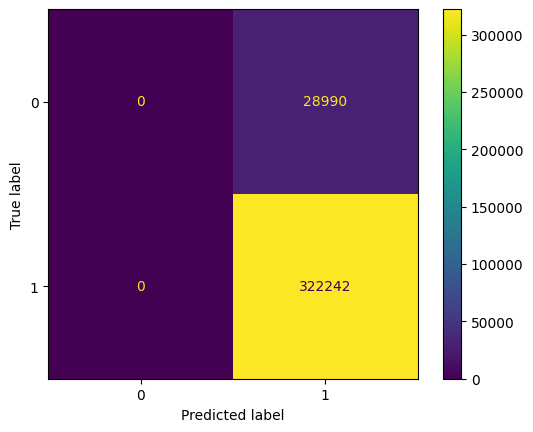

In [18]:
# # Train random forest on embeddings for gene detection to evaluate accuracy of predictions
if testbasic:
    X_genePresence = []  # features
    y_genePresence = []  # labels

    for sequence in embeddingsListForGenePresence:
        for embedChunk, labelChunk in sequence:
            for embed, label in zip(embedChunk, map(int, labelChunk)):
                X_genePresence.append(embed) # Embedding vectors for every k-mer
                y_genePresence.append(label) # Labels for every k-mer

    # Split and train
    X_trainPresence, X_testPresence, y_trainPresence, y_testPresence = train_test_split(X_genePresence, y_genePresence, stratify=y_genePresence, test_size=0.2, random_state=42)

    genePresenceClassifier = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    genePresenceClassifier.fit(X_trainPresence, y_trainPresence)

    # Evaluate
    y_predPresence = genePresenceClassifier.predict(X_testPresence)
    accuracyGenePresence = accuracy_score(y_testPresence, y_predPresence)
    print(f"Actual Gene Presence: {Counter(y_genePresence)}")
    print(f"Gene Presence Prediction Accuracy: {accuracyGenePresence:.4f}")
    print("F1 Score:", f1_score(y_testPresence, y_predPresence))
    print(classification_report(y_testPresence, y_predPresence, zero_division=0))
    confusionMatrix = confusion_matrix(y_testPresence, y_predPresence)
    ConfusionMatrixDisplay(confusion_matrix=confusionMatrix).plot()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


In [19]:
# # Binarize labels for gene type and remove labels for gene types that never appear
if testbasic:
    X_geneType = []  # features
    y_geneType = []  # labels
    allLabels = []
    for sequence in embeddingsListForGeneType:
        for embedChunk, labelChunk in sequence:
            for embed, label in zip(embedChunk, labelChunk):
                X_geneType.append(embed) # Embedding vectors for every k-mer
                if label == set():
                    allLabels.append([])
                else:
                    allLabels.append(list(label))
                
    # Binarize labels for y
    multiHotBinarizer = MultiLabelBinarizer(classes=allTypes)  # Fix the class order
    multiHotLabels = multiHotBinarizer.fit_transform(allLabels)  # Shape: (numKmers, numTypes)

    # Step 1: Get label frequency for each class (column)
    labelCounts = np.sum(multiHotLabels, axis=0)
    # Step 2: Identify columns with at least one positive label
    nonzeroIndices = np.where(labelCounts > 0)[0]
    # Step 3: Filter the multi-hot labels
    multiHotLabels = multiHotLabels[:, nonzeroIndices]
    # Step 4: Filter the class labels to match
    multiHotBinarizer.classes_ = multiHotBinarizer.classes_[nonzeroIndices]

    y_geneType = multiHotLabels
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['gene', 'misc_binding'] will be ignored
  warnings.warn(


Actual Gene Types:
  CDS: 1594503
  rRNA: 27664
  tRNA: 3754
  ncRNA: 378
  regulatory: 790
Hamming Loss: 0.02207828443877551
Micro F1 Score: 0.9426885094696326
Macro F1 Score: 0.192155917615133
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    318865
           1       0.81      0.00      0.01      5504
           2       0.00      0.00      0.00       700
           3       0.00      0.00      0.00        86
           4       0.00      0.00      0.00       170

   micro avg       0.91      0.98      0.94    325325
   macro avg       0.34      0.20      0.19    325325
weighted avg       0.90      0.98      0.93    325325
 samples avg       0.91      0.90      0.91    325325



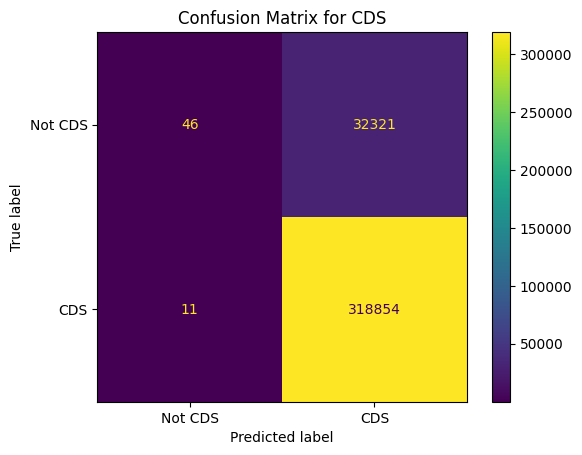

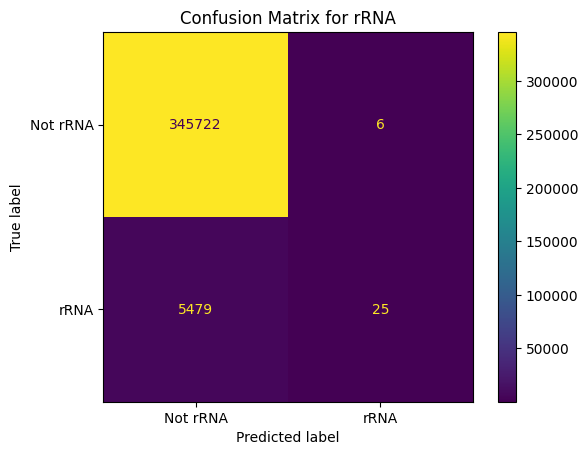

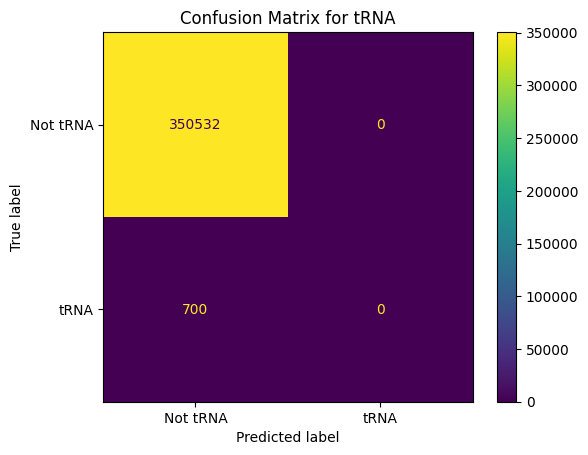

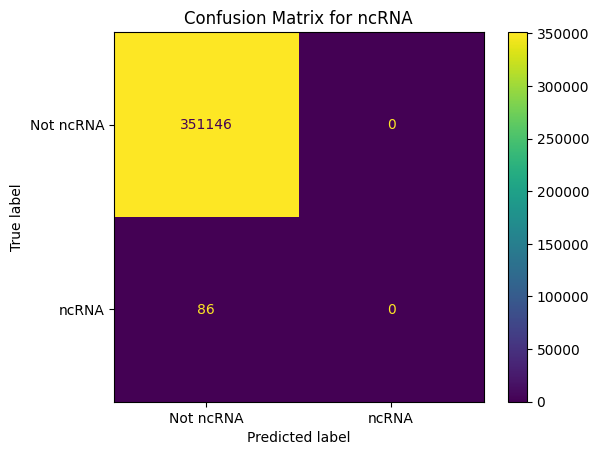

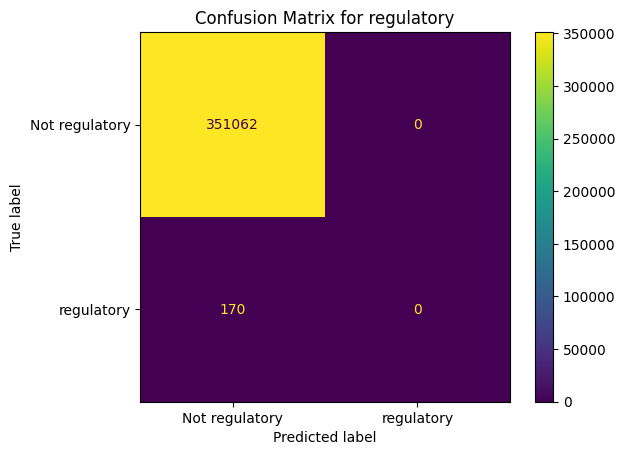

In [20]:
# # Train random forest on embeddings for gene classification to evaluate accuracy of predictions
if testbasic:
    # Split and train
    X_trainType, X_testType, y_trainType, y_testType = train_test_split(X_geneType, y_geneType, test_size=0.2, random_state=42)

    # Train classifier on gene types
    geneTypeClassifier = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
    geneTypeClassifier.fit(X_trainType, y_trainType)

    # Evaluate
    y_predType = geneTypeClassifier.predict(X_testType)

    # Sum columns to count how many times each gene type appears
    geneTypeCounts = np.sum(y_geneType, axis=0)

    # Print nicely
    print("Actual Gene Types:")
    for geneType, count in zip(multiHotBinarizer.classes_, geneTypeCounts):
        print(f"  {geneType}: {int(count)}")

    print("Hamming Loss:", hamming_loss(y_testType, y_predType))
    print("Micro F1 Score:", f1_score(y_testType, y_predType, average='micro'))
    print("Macro F1 Score:", f1_score(y_testType, y_predType, average='macro'))
    print(classification_report(y_testType, y_predType, zero_division=0))
    for i, geneType in enumerate(multiHotBinarizer.classes_):
        confusionMatrix = confusion_matrix(y_testType[:, i], y_predType[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=[f"Not {geneType}", geneType])
        disp.plot()
        plt.title(f"Confusion Matrix for {geneType}")
        plt.show()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


In [21]:
if testbasic:
    # Move original model to CPU
    model = model.to("cpu")  # move it off when not in use
    torch.cuda.empty_cache()
else:
    print("Project set to skip testing basic pretrained DNABERT model; this section skipped.")


In [ ]:
# # Process downloaded GBFF files for model input and/or fine-tuning
# # Most of the captured info is setup for downstream tasks, not necessarily within
# # project's scope

dataDirectory = "../data/downloads"

validGeneTypes = ["CDS", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]

# Optional for downstream tasks:
essentialGenomeElements = [
    "Sequence", "GenomeType", "Genes",
]
essentialGeneElements = [
    "GeneType", "LocusTag", "Start", "End", "GeneLength", "Strand", 
    "IntergenicDistance", "GCContent", "Organism", "RegulatoryClass", 
    "BoundMoiety", "Serovar", "Strain", "Subspecies"
]
OptionalGeneElements = ["GeneName"]

# Examples:
# Gene types:
# ['source', 'gene', 'CDS', 'regulatory', 'protein_bind', 'rRNA', 'tRNA', 'ncRNA', 'mobile_element', 'tmRNA', 'misc_RNA']

# Qualifiers:
# {
#     'organism': ['Salmonella enterica subsp. enterica serovar Typhimurium str. LT2'], 
#     'mol_type': ['genomic DNA'], 
#     'strain': ['LT2'], 
#     'serovar': ['Typhimurium'], 
#     'sub_species': ['enterica'], 
#     'culture_collection': ['ATCC:700720', 'SGSC:1412'], 
#     'type_material': ['type strain of Salmonella enterica'], 
#     'db_xref': ['taxon:99287'], 
#     'focus': [''],
#     'plasmid': ['pSLT']
# }
if directDownload:
    if not useEntrez: # We will still use Entrez for the taxonomy, so this runs only if it wasn't set in previous cells
        Entrez.email = os.getenv("NCBI_EMAIL", None)
        Entrez.api_key = os.getenv("NCBI_API_KEY", None)

    data = []
    for i, filename in enumerate(os.listdir(dataDirectory)):
        if filename.endswith(".gbff"):
            fullPath = os.path.join(dataDirectory, filename)
            print(f"processing File {i}: {fullPath}")
            # Read the file and parse it as a GenBank record
            with open(fullPath, "r") as input:
                for record in SeqIO.parse(input, "genbank"):
                    accessionNum = record.id
                    genome = record.seq
                    genomeLength = len(genome)
                    description = record.description
                    genomeType = "plasmid" if "plasmid" in description.lower() else "chromo"
                    organism = None
                    subspecies = None
                    moleculeType = None
                    strain = None
                    serovar = None
                    taxonID = None
                    host = None

                    # print(f"Accession: {record.id}")
                    # print(f"Genome Length: {genomeLength} bp")
                    # print(f"Type of genome: {genomeType}")
                    # print(f"Description: {description}")
                                            
                    sourceRegions = None
                    genes = []
                    for gene in record.features:
                        geneType = gene.type
                        geneName = None
                        locusTag = None
                        geneStart = gene.location.start
                        geneEnd = gene.location.end
                        strand = "+" if gene.location.strand == 1 else "-"
                        geneSequence = genome[geneStart:geneEnd]
                        GCContent = (geneSequence.count("G") + geneSequence.count("C")) / len(geneSequence) if len(geneSequence) > 0 else 0

                        proteinProduct = None
                        aminoAcidSeq = None
                        regClass = None
                        boundMoiety = None
                        RNAProduct = None
                        ncRNAClass = None
                        elementType = None

                        # Store all `source` regions
                        if geneType == "source":
                            organism = gene.qualifiers.get("organism", [None])[0]
                            subspecies = gene.qualifiers.get("sub_species", [None])[0]
                            moleculeType = gene.qualifiers.get("mol_type", [None])[0]
                            strain = gene.qualifiers.get("strain", [None])[0]
                            serovar = gene.qualifiers.get("serovar", [None])[0]
                            host = gene.qualifiers.get("host", [None])[0]
                            taxonID = gene.qualifiers.get("db_xref", [None])[0]
                            continue
                        if geneType not in validGeneTypes + validOtherTypes:
                            continue
                        if geneType == "mobile_element":
                            elementType = gene.qualifiers.get("mobile_element_type", [None])[0]
                        elif geneType == "protein_bind":
                            boundMoiety = gene.qualifiers.get("bound_moiety", [None])[0]
                        else:
                            geneName = gene.qualifiers.get("gene", [None])[0]
                            locusTag = gene.qualifiers.get("locus_tag", [None])[0]
                            # Extract protein-coding information
                            if geneType == "CDS":
                                proteinProduct = gene.qualifiers.get("product", [None])[0]
                                aminoAcidSeq = gene.qualifiers.get("translation", [None])[0]
                            elif geneType == "regulatory":
                                regClass = gene.qualifiers.get("regulatory_class", [None])[0]
                            elif geneType == "ncRNA":
                                ncRNAClass = gene.qualifiers.get("ncRNA_class", [None])[0]
                            elif geneType != "gene":
                                RNAProduct = gene.qualifiers.get("product", [None])[0]

                        previousGeneEnd = None
                        for prevGene in reversed(genes):  # Search backward
                            if prevGene["Strand"] == strand:  # Only consider same-strand genes from same source
                                previousGeneEnd = prevGene["End"]
                                break
                        intergenicDistance = geneStart - previousGeneEnd if previousGeneEnd is not None else None
                        # print(f"Gene: {geneName}, Location: {geneStart}-{geneEnd}, Strand: {strand}")

                        # Store extracted features
                        genes.append({
                            "GeneType": geneType,
                            "GeneName": geneName,
                            "LocusTag": locusTag,
                            "Start": geneStart,
                            "End": geneEnd,
                            "Strand": strand,
                            "GeneLength": len(geneSequence),
                            "GCContent": GCContent,
                            "ElementType": elementType,
                            "BoundMoiety": boundMoiety,
                            "ProteinProduct": proteinProduct,
                            "AminoAcidSeq": aminoAcidSeq,
                            "RegulatoryClass": regClass,
                            "ncRNAClass": ncRNAClass,
                            "RNAProduct": RNAProduct,
                            "IntergenicDistance": intergenicDistance,
                        })
                    if taxonID:
                        taxonomy = getTaxonomyRanks(taxonID)
                        
                        domain = taxonomy.get("Domain", None)
                        kingdom = taxonomy.get("Kingdom", None)
                        phylum = taxonomy.get("Phylum", None)
                        className = taxonomy.get("Class", None)
                        order = taxonomy.get("Order", None)
                        family = taxonomy.get("Family", None)
                        genus = taxonomy.get("Genus", None)
                        species = taxonomy.get("Species", None)

                    data.append({
                        "Accession": accessionNum,
                        "Organism": organism,
                        "Subspecies": subspecies,
                        "MoleculeType": moleculeType,
                        "Strain": strain,
                        "Serovar": serovar,
                        "Domain": domain,
                        "Kingdom": kingdom,
                        "Phylum": phylum,
                        "Class": className,
                        "Order": order,
                        "Family": family,
                        "Genus": genus,
                        "Species": species,
                        "GenomeLength": genomeLength,
                        "Sequence": genome,
                        "Description": description,
                        "GenomeType": genomeType,
                        "Host": host,
                        "Genes": genes
                    })
        print(f"Total number of sequences: {len(data)}")
    print(f"Final total number of sequences: {len(data)}")
else:
    print("Project set to use remote fetching via Entrez API; this section skipped")


processing File 0: ../data/downloads\71720138.gbff
Total number of sequences: 4
processing File 1: ../data/downloads\71720458.gbff
Total number of sequences: 7
processing File 2: ../data/downloads\71759168.gbff
Total number of sequences: 8
processing File 3: ../data/downloads\71759988.gbff
Total number of sequences: 10
processing File 4: ../data/downloads\71805988.gbff
Total number of sequences: 11
processing File 5: ../data/downloads\71806308.gbff
Total number of sequences: 12
processing File 6: ../data/downloads\71844268.gbff
Total number of sequences: 21
processing File 7: ../data/downloads\71848628.gbff
Total number of sequences: 23
processing File 8: ../data/downloads\72082058.gbff
Total number of sequences: 24
processing File 9: ../data/downloads\72083138.gbff
Total number of sequences: 25
processing File 10: ../data/downloads\genomic_GCF_000007365.1.gbff
Total number of sequences: 26
processing File 11: ../data/downloads\genomic_GCF_000007505.1.gbff
Total number of sequences: 28

In [23]:
# # Subset and truncate input sequences to workable sizes

numGenomes = len(data) # len(data) removes truncation for this testing cycle
truncateLength = 10000000 # Longest sequence is < 10000000 base pairs, so 10000000 will not truncate
dataSubset = []

if numGenomes <= len(data): # Randomly picks numGenomes genomes from the input list
    for i in range(numGenomes):
        randIdx = random.randint(0, len(data) - 1)
        while data[randIdx] in dataSubset:
            randIdx = random.randint(0, len(data) - 1)

        if len(data[randIdx]["Sequence"]) > truncateLength: # Truncate sequences longer than truncateLength bp, may extend for greater accuracy
            print(f"Truncated sequence {randIdx}")
            data[randIdx]["Sequence"] = data[randIdx]["Sequence"][0:truncateLength - 1]
            for gene in data[randIdx]["Genes"]: # Remove genes on deleted part of sequence
                if gene["Start"] > truncateLength  or gene["End"] > truncateLength:
                    data[randIdx]["Genes"].remove(gene)
        dataSubset.append(data[randIdx])
        print(f"{randIdx}: {len(dataSubset[i]["Sequence"])}")


1: 96883
10: 3397546
33: 38454
83: 73345
56: 72460
76: 49266
37: 3809201
111: 93933
7: 9599576
28: 6397126
78: 18445
90: 32586
97: 4498248
96: 1886760
65: 151583
59: 1326
93: 46368
73: 2180101
100: 3567
58: 26706
20: 52076
53: 2762785
68: 4058311
15: 161663
94: 7842
110: 4857450
34: 22870
42: 141504
9: 10647
21: 5016258
11: 3884372
79: 4924764
38: 2914771
24: 3606378
0: 3208966
99: 29147
57: 2924929
19: 2003
48: 161613
72: 147076
66: 4857439
16: 24833
64: 4748414
105: 1953654
98: 2465028
92: 2695389
103: 4586140
25: 641454
88: 57214
106: 1931548
67: 95331
52: 7553
89: 3271838
108: 817125
43: 38579
104: 6868303
29: 73661
27: 1207381
30: 67473
77: 1898076
107: 4610200
50: 1003404
17: 321572
87: 4588714
95: 3803549
112: 4411532
12: 3646165
54: 24853
40: 3843301
2: 133931
60: 2463666
41: 5943768
91: 73132
5: 104898
14: 3399615
31: 3814128
75: 3622107
70: 5400144
51: 1171667
84: 4492589
6: 151497
47: 4969811
36: 1469720
85: 108549
71: 3357452
82: 5876902
63: 9106064
62: 3155838
23: 3762804


In [24]:
# # Subset sequences further based on lowest prevalence of CDS genes for best distributions of the dataset
numSequences = 10
sortedData = []

allTypes = validGeneTypes + validOtherTypes
allTotal = 0
for s, sequence in enumerate(dataSubset):
    geneCounter = Counter()
    for i, gene in enumerate(sequence["Genes"]):
        geneCounter[gene["GeneType"]] += 1
    total = sum(geneCounter.values())
    sortedData.append((s, (geneCounter["CDS"] / total) * 100 if total > 0 else 0))
    print(f"Sequence {s + 1}:")
    for geneType in allTypes:
        print(f"  {geneType}: {(geneCounter[geneType] / total) * 100 if total > 0 else 0}")
    print(f"Total genes: {total}\n")
    allTotal += total
print(f"Final Total genes: {allTotal}\n")

if numSequences <= len(dataSubset): # Sorts sequences by CDS prevalence and only filters out all but least CDS-dominant
    sortedData = sorted(sortedData, key=lambda item: item[1])
    print(sortedData)
    keptIndices = []
    for i in range(numSequences):
        keptIndices.append(sortedData[i][0])
    print(keptIndices)

    dataSubset = [dataSubset[i] for i in keptIndices]
print(len(dataSubset))


Sequence 1:
  CDS: 50.0
  rRNA: 0.0
  tRNA: 0.0
  ncRNA: 0.0
  tmRNA: 0.0
  misc_RNA: 0.0
  regulatory: 0.0
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 248

Sequence 2:
  CDS: 48.35144927536232
  rRNA: 0.2717391304347826
  tRNA: 1.25
  ncRNA: 0.018115942028985508
  tmRNA: 0.018115942028985508
  misc_RNA: 0.0
  regulatory: 0.16304347826086957
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 5520

Sequence 3:
  CDS: 49.45054945054945
  rRNA: 0.0
  tRNA: 0.0
  ncRNA: 0.0
  tmRNA: 0.0
  misc_RNA: 0.0
  regulatory: 1.098901098901099
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 91

Sequence 4:
  CDS: 50.0
  rRNA: 0.0
  tRNA: 0.0
  ncRNA: 0.0
  tmRNA: 0.0
  misc_RNA: 0.0
  regulatory: 0.0
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 142

Sequence 5:
  CDS: 50.0
  rRNA: 0.0
  tRNA: 0.0
  ncRNA: 0.0
  tmRNA: 0.0
  misc_RNA: 0.0
  regulatory: 0.0
  protein_bind: 0.0
  mobile_element: 0.0
Total genes: 176

Sequence 6:
  CDS: 50.0
  rRNA: 0.0
  tRNA: 0.0
  ncRN

In [25]:
# # Create labels and chunks for gene identification and classification for each genome

def extractGeneLocations(record):
    """
    Extracts start and end positions of all genes in a GBFF record.

    record: Actual genome record with organism info + genes list

    Returns list of 3-tuples with gene ranges and their types.
    """
    geneRanges = []
    for gene in record["Genes"]:
        start = int(gene["Start"])
        end = int(gene["End"])
        type = gene["GeneType"]
        geneRanges.append((start, end, type))

    return geneRanges

def buildTreeForGenePresence(geneRanges):
    """
    Builds an interval tree that stores gene presence for fast gene lookup.
    
    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair intervals marked 1 if a gene exist, 
    0 otherwise.
    """
    tree = IntervalTree()

    for start, end, geneType in geneRanges:
        tree[start:end] = 1  # Store a value (1) to mark gene presence

    return tree

def buildTreeForGeneType(geneRanges):
    """
    Builds an interval tree that stores gene type info per interval.

    geneRanges: List of 3-tuples in the form (start, end, geneType)

    Returns IntervalTree with base pair interval sets containing 
    string names of overlapping gene types.
    """
    tree = IntervalTree()
    
    for start, end, geneType in geneRanges:
        overlapping = tree[start:end]

        if overlapping:
            # Remove old and replace with merged intervals
            tree.chop(start, end)  # Cut out overlapping region
            tree[start:end] = {geneType}
            for interval in overlapping:
                overlap_start = max(start, interval.begin)
                overlap_end = min(end, interval.end)
                combined_data = set(interval.data) | {geneType}
                tree[overlap_start:overlap_end] = combined_data
        else:
            tree[start:end] = {geneType}

    return tree

def chunkRawSequence(sequence, windowSize=512 * 6, stride=256 * 6):
    '''
    Convert long sequence into overlapping chunks of (512 * 6 by default) base pairs.

    sequence (string): Raw genome sequence
    windowSize (int): Width of window for input into model (512 * 6 for 512 6-mers)
    stride (int): Amount of overlap between windows

    Returns list of overlapping window strings of length len(sequence) - windowSize + 1.
    '''
    return [sequence[i:i+windowSize] for i in range(0, len(sequence) - windowSize + 1, stride)]

def labelSequenceChunk(startOffset, numKmers, k=6, treePresence=None, treeType=None):
    """
    Given a window of a sequence and its start offset in the original sequence,
    return gene presence and gene type labels for each k-mer in the window.

    startOffset (int): Base pair offset of current chunk
    numKmers (int): Total number of k-mers per chunk
    k (int): K-mer size (6-mers by default)
    treePresence: Reference to IntervalTree for gene presence/detection
    treeType: Reference to IntervalTree for gene type classification

    Returns tuple in the form (presenceLabels, typeLabels) where each element 
    is a list of int or set() labels respectively.
    """
    presenceLabels = []
    typeLabels = []

    for i in range(numKmers):
        kmerStart = startOffset + i
        kmerEnd = kmerStart + k

        # Gene Presence
        if treePresence:
            present = 1 if treePresence[kmerStart] else 0
            presenceLabels.append(present)

        # Gene Type
        if treeType:
            geneTypes = set()
            for interval in treeType[kmerStart:kmerEnd]:
                geneTypes.update(interval.data)
            typeLabels.append(geneTypes)

    return presenceLabels, typeLabels

kmersList = []
embeddingsListForGenePresence = []
embeddingsListForGeneType = []
labelsListForGenePresence = []
labelsListForGeneType = []

k = 6
numKmers = 512
windowSize = numKmers * k # Gives 512 6-mers
stride = 256

for i, input in enumerate(dataSubset):
    print(f"Sequence {i + 1}:")
    sequence = str(input["Sequence"])
    # print(len(sequence))
    geneRanges = extractGeneLocations(input)
    # print(len(geneRanges))
    intervalTreeForGenePresence = buildTreeForGenePresence(geneRanges)
    intervalTreeForGeneType = buildTreeForGeneType(geneRanges)

    windows = chunkRawSequence(sequence, windowSize, stride)
    if not windows:
        print(f"Sequence {i + 1} skipped — too short for window size {windowSize}. Length: {len(sequence)} bp")
        continue

    for j, window in enumerate(windows):
        # Convert k-mer list back to space-separated string to avoid dimensional issues
        kmers = [window[i:i+k] for i in range(0, len(window), k)]
        kmerString = " ".join(kmers)

        # Generate labels for this window
        startbp = j * stride
        # Label per-k-mer based on interval tree and raw sequence position
        presenceLabels, typeLabels = labelSequenceChunk(
            startOffset=startbp,
            numKmers=numKmers,
            k=k,
            treePresence=intervalTreeForGenePresence,
            treeType=intervalTreeForGeneType
        )
        print(f"Sequence {i + 1}: Chunk {j + 1} out of {len(windows)}")
        
        labelsListForGenePresence.append((kmerString, presenceLabels))
        labelsListForGeneType.append((kmerString, typeLabels))
    print("Finished!")


Sequence 1:
Sequence 1: Chunk 1 out of 18963
Sequence 1: Chunk 2 out of 18963
Sequence 1: Chunk 3 out of 18963
Sequence 1: Chunk 4 out of 18963
Sequence 1: Chunk 5 out of 18963
Sequence 1: Chunk 6 out of 18963
Sequence 1: Chunk 7 out of 18963
Sequence 1: Chunk 8 out of 18963
Sequence 1: Chunk 9 out of 18963
Sequence 1: Chunk 10 out of 18963
Sequence 1: Chunk 11 out of 18963
Sequence 1: Chunk 12 out of 18963
Sequence 1: Chunk 13 out of 18963
Sequence 1: Chunk 14 out of 18963
Sequence 1: Chunk 15 out of 18963
Sequence 1: Chunk 16 out of 18963
Sequence 1: Chunk 17 out of 18963
Sequence 1: Chunk 18 out of 18963
Sequence 1: Chunk 19 out of 18963
Sequence 1: Chunk 20 out of 18963
Sequence 1: Chunk 21 out of 18963
Sequence 1: Chunk 22 out of 18963
Sequence 1: Chunk 23 out of 18963
Sequence 1: Chunk 24 out of 18963
Sequence 1: Chunk 25 out of 18963
Sequence 1: Chunk 26 out of 18963
Sequence 1: Chunk 27 out of 18963
Sequence 1: Chunk 28 out of 18963
Sequence 1: Chunk 29 out of 18963
Sequence 1:

In [26]:
# # View gene/non-gene and gene type distributions from entire subset

total1s = 0
total0s = 0
for i, (kmers, labels) in enumerate(labelsListForGenePresence):
    for label in labels:
        Zcount = 0
        Ocount = 0
        if label == 0:
            Zcount += 1
            total0s += 1
        if label == 1:
            Ocount += 1
            total1s += 1
    # print(f"Chunk {i + 1}: 0s: {Zcount}, 1s: {Ocount}, Total: {Zcount + Ocount}")
print(f"Total: 0s: {total0s}, 1s: {total1s}, Total: {total0s + total1s}")

# validGeneTypes = ["CDS", "gene", "rRNA", "tRNA", "ncRNA", "tmRNA", "misc_RNA"]
# validOtherTypes = ["regulatory", "protein_bind", "mobile_element"]
allTypes = validGeneTypes + validOtherTypes
typeCounter = Counter()
for i, (kmers, labels) in enumerate(labelsListForGeneType):
    for labelSet in labels:
        for geneType in labelSet:
            if geneType in allTypes:
                typeCounter[geneType] += 1
total = sum(typeCounter.values())

for geneType in allTypes:
    print(f"  {geneType}: {(typeCounter[geneType] / total) * 100}%")
print(f"  Total labeled kmers: {total}\n")


Total: 0s: 3699762, 1s: 40208334, Total: 43908096
  CDS: 97.82231073799062%
  rRNA: 1.1625845459869093%
  tRNA: 0.23622895121158247%
  ncRNA: 0.04355700105694002%
  tmRNA: 0.013585588925756167%
  misc_RNA: 0.003388976115856873%
  regulatory: 0.2902991993432609%
  protein_bind: 0.042364675153404974%
  mobile_element: 0.38568032421567655%
  Total labeled kmers: 40425189



In [27]:
# # Fine-tuning for gene detection

def computeMetricsPresence(eval_pred):
    """Compute accuracy, precision, recall, and F1 for binary classification."""
    logits, labels = eval_pred
    predictions = logits.argmax(-1)  # Get the predicted class (0 or 1)
    # Flatten to treat every token's prediction equally
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

class GenePresenceDataset(Dataset):
    def __init__(self, kmer_texts, labels, tokenizer, max_length=512):
        # Store inputs: list of strings and labels (e.g., ["ATG CGT GCA...", ...], [0, 1, 0, ...])
        self.kmer_texts = kmer_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length  # DNABERT can handle up to 512 tokens

    def __len__(self):
        return len(self.kmer_texts)

    def __getitem__(self, idx):
        text = self.kmer_texts[idx]     # The k-mer string for one sequence chunk
        label = self.labels[idx]        # List of 512 binary labels for token-level gene presence

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"   # Returns PyTorch tensors instead of lists
        )
        # Remove batch dimension
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs["labels"] = torch.tensor(label)
        return inputs

kmers, labelsPresence = zip(*labelsListForGenePresence)
kmersTrainPresence, kmersEvalPresence, labelsTrainPresence, labelsEvalPresence = train_test_split(kmers, labelsPresence, test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)

trainDatasetPresence = GenePresenceDataset(kmersTrainPresence, labelsTrainPresence, tokenizer)
evalDatasetPresence = GenePresenceDataset(kmersEvalPresence, labelsEvalPresence, tokenizer)

genePresenceModel = BertForTokenClassification.from_pretrained("zhihan1996/DNA_bert_6", num_labels=2)
# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")
if device == "cuda":
    genePresenceModel = genePresenceModel.to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [28]:
# Define training arguments
trainingArgsPresence = TrainingArguments(
    output_dir="./GeneDetectionModel",
    num_train_epochs=2,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",              # Save frequently in case of crashes, if "steps", eval_strat must also be "steps"
    # save_steps=10000,                 # Save every 10000 steps
    # save_total_limit=3,               # Keep only the 3 most recent checkpoints
    logging_dir="./logsGenePresence",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True
)

# Define Trainer
trainerPresence = Trainer(
    model=genePresenceModel,
    args=trainingArgsPresence,
    train_dataset=trainDatasetPresence,
    eval_dataset=evalDatasetPresence,
    tokenizer=tokenizer,
    compute_metrics=computeMetricsPresence
)

# Train DNABert
trainerPresence.train()


C:\Users\musti\AppData\Local\Temp\ipykernel_37540\529435688.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainerPresence = Trainer(


TrainOutput(global_step=11436, training_loss=0.1705870539961098, metrics={'train_runtime': 5392.6043, 'train_samples_per_second': 25.444, 'train_steps_per_second': 2.121, 'total_flos': 3.585305058526003e+16, 'train_loss': 0.1705870539961098, 'epoch': 2.0})

Final Evaluation Metrics:
Accuracy : 0.9456
Precision: 0.9659
Recall   : 0.9752
F1-score : 0.9705


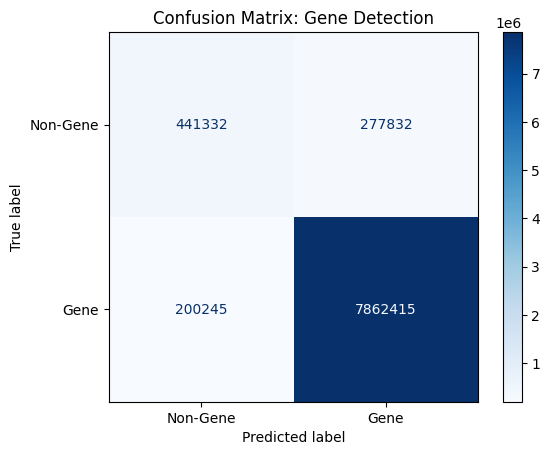

In [29]:
# # Evaluation for gene detection
# Step 1: Run predictions on eval dataset
predsPresence = trainerPresence.predict(evalDatasetPresence)

# Step 2: Extract raw logits and labels
logits = predsPresence.predictions  # shape: (batch_size, sequence_length, num_labels)
trueLabels = predsPresence.label_ids  # shape: (batch_size, sequence_length)

# Step 3: Convert logits to predicted classes
predictions = np.argmax(logits, axis=-1)  # shape: (batch_size, sequence_length)

# Step 4: Flatten everything to 1D (optional masking if needed)
flatPreds = predictions.flatten()
flatLabels = trueLabels.flatten()

# Step 5: Compute metrics
acc = accuracy_score(flatLabels, flatPreds)
precision, recall, f1, _ = precision_recall_fscore_support(flatLabels, flatPreds, average='binary')

print("Final Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Step 6: Plot confusion matrix
cm = confusion_matrix(flatLabels, flatPreds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Gene", "Gene"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Gene Detection")
plt.show()


In [30]:
# Move original model to CPU
genePresenceModel = genePresenceModel.to("cpu")  # move it off when not in use
torch.cuda.empty_cache()


In [31]:
# # Fine-tuning for gene classification

kmers, labelsType = map(list, zip(*labelsListForGeneType))

# Flatten just to fit the binarizer once (to establish column order)
flatLabelList = [list(label) for chunk in labelsType for label in chunk]

multiHotBinarizer = MultiLabelBinarizer(classes=allTypes)  # Ensure consistent label order
multiHotBinarizer.fit(flatLabelList)

# Binarize labels per chunk
multiHotLabels = []
for chunk in labelsType:
    labelList = [list(label) for label in chunk]
    binarizedChunk = multiHotBinarizer.transform(labelList)  # Shape: (numKmers, numTypes)
    multiHotLabels.append(binarizedChunk)

# Step 1: Get label frequency for each class (column)
labelCounts = np.sum(np.vstack(multiHotLabels), axis=0)
# Step 2: Identify columns with at least one positive label
nonzeroIndices = np.where(labelCounts > 0)[0]
# Step 3: Filter the multi-hot labels by chunk
multiHotLabels = [chunk[:, nonzeroIndices] for chunk in multiHotLabels]
# Step 4: Filter the class labels to match
multiHotBinarizer.classes_ = multiHotBinarizer.classes_[nonzeroIndices]


c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['gene'] will be ignored
  warnings.warn(
c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['gene', 'repeat_region'] will be ignored
  warnings.warn(
c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['gene', 'misc_feature'] will be ignored
  warnings.warn(
c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['gene', 'misc_feature', 'repeat_region'] will be ignored
  warnings.warn(
c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\preprocessi

In [32]:
class BertForMultilabelTokenClassification(BertForTokenClassification):
    '''Wrapper class of BertForTokenClassification to force BCEWithLogitsLoss for multi-labels'''
    def __init__(self, config):
        super().__init__(config)
        self.loss_fct = nn.BCEWithLogitsLoss() # Replaces CrossEntropyLoss with Binary Cross Entropy with Logits

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Remove Trainer-injected argument that causes crash
        kwargs.pop("num_items_in_batch", None)

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )

        # Get model's raw outputs before sigmoid
        logits = outputs.logits  # shape: [batch_size, seq_len, num_labels]

        loss = None
        if labels is not None:
            # Make sure label shape matches logits
            loss = self.loss_fct(logits, labels.float())  # Floats for BCEWithLogitsLoss

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}


def computeMetricsType(eval_pred):
    """Compute f1-scores (micro and macro), precision, and recall for multi-label token classification."""
    logits, labels = eval_pred

    # Apply sigmoid for multi-label classification
    probs = 1 / (1 + np.exp(-logits))  # shape: (batch, seq_len, num_classes)
    
    # Apply threshold
    preds = (probs >= 0.5).astype(int)  # binary predictions - Raise threshold from 0.5 to reduce false positives

    # Flatten all tokens across the batch
    flat_preds = preds.reshape(-1, preds.shape[-1])
    flat_labels = labels.reshape(-1, labels.shape[-1])

    return {
        "f1_micro": f1_score(flat_labels, flat_preds, average='micro', zero_division=0),
        "precision_micro": precision_score(flat_labels, flat_preds, average='micro', zero_division=0),
        "recall_micro": recall_score(flat_labels, flat_preds, average='micro', zero_division=0),
        "f1_macro": f1_score(flat_labels, flat_preds, average='macro', zero_division=0),
        "precision_macro": precision_score(flat_labels, flat_preds, average='macro', zero_division=0),
        "recall_macro": recall_score(flat_labels, flat_preds, average='macro', zero_division=0)
    }

class GeneTypeDataset(Dataset):
    def __init__(self, kmer_texts, labels, tokenizer, num_classes, max_length=512):
        # Store inputs: list of strings and labels (e.g., ["ATG CGT GCA...", ...], [0, 1, 0, ...])
        self.kmer_texts = kmer_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length  # DNABERT can handle up to 512 tokens
        self.num_classes = num_classes

    def __len__(self):
        return len(self.kmer_texts)

    def __getitem__(self, idx):
        text = self.kmer_texts[idx]     # The k-mer string for one sequence chunk
        label = self.labels[idx]        # List of 512 multihot label lists for token-level gene classification

        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"   # Returns PyTorch tensors instead of lists
        )
        # Remove batch dimension
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        # Convert label to tensor (shape [512, num_classes])
        inputs["labels"] = torch.tensor(label, dtype=torch.float)  # important: float for BCEWithLogitsLoss
        return inputs

kmersTrainType, kmersEvalType, labelsTrainType, labelsEvalType = train_test_split(kmers, multiHotLabels, test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)

trainDatasetType = GeneTypeDataset(kmersTrainType, labelsTrainType, tokenizer, len(multiHotBinarizer.classes_))
evalDatasetType = GeneTypeDataset(kmersEvalType, labelsEvalType, tokenizer, len(multiHotBinarizer.classes_))

config = AutoConfig.from_pretrained("zhihan1996/DNA_bert_6", num_labels=len(multiHotBinarizer.classes_)) # Override base BERT's num_classes via config
geneTypeModel = BertForMultilabelTokenClassification.from_pretrained("zhihan1996/DNA_bert_6", config=config) # Initialize wrapper class BERT model
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")
if device == "cuda":
    geneTypeModel = geneTypeModel.to(device)


Some weights of BertForMultilabelTokenClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [ ]:
# Define training arguments
trainingArgsType = TrainingArguments(
    output_dir="./GeneClassificationModel",
    num_train_epochs=2,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",              # Save frequently in case of crashes, if "steps", eval_strat must also be "steps"
    # save_steps=10000,                 # Save every 10000 steps
    # save_total_limit=3,              # Keep only the 3 most recent checkpoints
    logging_dir="./logsGeneType",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True  # use if you're training on GPU and have memory constraints
)

# Define Trainer
trainerType = Trainer(
    model=geneTypeModel,
    args=trainingArgsType,
    train_dataset=trainDatasetType,
    eval_dataset=evalDatasetType,
    tokenizer=tokenizer,
    compute_metrics=computeMetricsType
)

trainerType.train()


C:\Users\musti\AppData\Local\Temp\ipykernel_37540\3607005941.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainerType = Trainer(


In [ ]:
# # Evaluation for gene classification
# Step 1: Run predictions on eval dataset
predsType = trainerType.predict(evalDatasetType)

# Step 2: Extract raw logits and labels
logits = predsType.predictions  # shape: (batch_size, sequence_length, num_labels)
trueLabels = predsType.label_ids  # shape: (batch_size, sequence_length)

# Step 3: Apply sigmoid to get probabilities, then threshold
probs = 1 / (1 + np.exp(-logits))  # sigmoid
predictions = (probs >= 0.5).astype(int)  # Change threshold to re-evaluate at different precisions

# Step 4: Flatten everything to 1D
flatPreds = predictions.reshape(-1, predictions.shape[-1])
flatLabels = trueLabels.reshape(-1, trueLabels.shape[-1])

# Step 5: Compute metrics
print("Multi-label Token Classification Report:")
print(classification_report(flatLabels, flatPreds, target_names=multiHotBinarizer.classes_, zero_division=0))

# Step 6: Confusion matrices per class
multiConfusionMatrix = multilabel_confusion_matrix(flatLabels, flatPreds)
for i, geneType in enumerate(multiHotBinarizer.classes_):
    print(f"\nConfusion Matrix for {geneType}:")
    print(multiConfusionMatrix[i])

# Step 7: Macro/micro scores explicitly
from sklearn.metrics import f1_score, precision_score, recall_score
print("\nSummary Stats:")
print(f"Micro F1     : {f1_score(flatLabels, flatPreds, average='micro'):.4f}")
print(f"Micro Precision: {precision_score(flatLabels, flatPreds, average='micro'):.4f}")
print(f"Micro Recall   : {recall_score(flatLabels, flatPreds, average='micro'):.4f}")
print(f"Macro F1     : {f1_score(flatLabels, flatPreds, average='macro'):.4f}")
print(f"Macro Precision: {precision_score(flatLabels, flatPreds, average='macro'):.4f}")
print(f"Macro Recall   : {recall_score(flatLabels, flatPreds, average='macro'):.4f}")




📊 Multi-label Token Classification Report:
                precision    recall  f1-score   support

           CDS       0.96      0.97      0.97   7058753
          rRNA       0.91      0.93      0.92     95576
          tRNA       0.51      0.23      0.32     20962
         ncRNA       0.00      0.00      0.00      2919
         tmRNA       0.00      0.00      0.00      1406
    regulatory       0.00      0.00      0.00     25270
  protein_bind       0.00      0.00      0.00      3275
mobile_element       0.00      0.00      0.00      1838

     micro avg       0.96      0.96      0.96   7209999
     macro avg       0.30      0.27      0.28   7209999
  weighted avg       0.96      0.96      0.96   7209999
   samples avg       0.89      0.88      0.88   7209999


Confusion Matrix for CDS:
[[ 532768  261535]
 [ 198828 6859925]]

Confusion Matrix for rRNA:
[[7749070    8410]
 [   6231   89345]]

Confusion Matrix for tRNA:
[[7827389    4705]
 [  16088    4874]]

Confusion Matrix for ncRN

c:\Users\musti\Documents\GitHub\Bacterial-Gene-Identification-ML-Model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision: 0.2983
Macro Recall   : 0.2674
